<a href="https://colab.research.google.com/github/roni762583/NEAT/blob/main/NEAT_FX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
!pip install neat-python
!pip install visualize==0.5.1

import neat
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving config-feedforward to config-feedforward (1)


In [112]:
# import local config file
from google.colab import files
uploaded = files.upload() 
config_file = list(uploaded.keys())[0]
# make sure pandas doesn’t hide any columns
pd.set_option("display.max.columns", None)

Saving config-feedforward to config-feedforward


In [113]:
#!rm -f config*
!ls -la


total 44820
drwxr-xr-x 1 root root     4096 Sep 27 19:54 .
drwxr-xr-x 1 root root     4096 Sep 27 12:47 ..
drwxr-xr-x 4 root root     4096 Sep 22 13:41 .config
-rw-r--r-- 1 root root     1920 Sep 27 19:54 config-feedforward
-rw-r--r-- 1 root root 45871683 Sep 27 13:06 DAT_ASCII_GBPUSD_T_201704.csv
drwxr-xr-x 1 root root     4096 Sep 22 13:42 sample_data


In [2]:
# import price data
!ls

from google.colab import files
uploaded = files.upload() 
filename = list(uploaded.keys())[0]
colnames=['TIME', 'bid', 'ask', 'tradable'] 
df = pd.read_csv(filename, names=colnames, header=None)
print(df.head())
print(df.dtypes)
df['datetime'] = pd.to_datetime( df['TIME'], format='%Y%m%d %H%M%S%f' )
df.head()
# Don't set datetime as index column to aid in label synthesis below
# df.set_index(df['datetime'], inplace = True)
# df.head
# drop extra columns
df.drop(['TIME','tradable'], axis=1, inplace=True) # keep 'datetime',
print("Shape: ",df.shape)
print(df.head())
print("count: ",df.count())

config-feedforward  sample_data


Saving DAT_ASCII_GBPUSD_T_201704.csv to DAT_ASCII_GBPUSD_T_201704.csv
                 TIME      bid      ask  tradable
0  20170402 170030610  1.25435  1.25515         0
1  20170402 170205110  1.25435  1.25515         0
2  20170402 170208110  1.25475  1.25555         0
3  20170402 170338860  1.25420  1.25500         0
4  20170402 170344610  1.25425  1.25505         0
TIME         object
bid         float64
ask         float64
tradable      int64
dtype: object
Shape:  (1176197, 3)
       bid      ask                datetime
0  1.25435  1.25515 2017-04-02 17:00:30.610
1  1.25435  1.25515 2017-04-02 17:02:05.110
2  1.25475  1.25555 2017-04-02 17:02:08.110
3  1.25420  1.25500 2017-04-02 17:03:38.860
4  1.25425  1.25505 2017-04-02 17:03:44.610
count:  bid         1176197
ask         1176197
datetime    1176197
dtype: int64


In [3]:
# build Hull Moving Avg. as features of environment
def WMA(s, period):
       return s.rolling(period).apply(lambda x: ((np.arange(period)+1)*x).sum()/(np.arange(period)+1).sum(), raw=True)

def HMA(s, period):
       return WMA(WMA(s, period//2).multiply(2).sub(WMA(s, period)), int(np.sqrt(period)))

#df["hma5"] = HMA(df.bid, 5) # took >32 sec. to run on 1.08MM rows
#df['deltahma5'] = df.hma5.diff()
#df['deltahma5_5'] = df.hma5.diff(5)
#df['hma5hma5'] = HMA(df.hma5, 5)
#df['deltahma5hma5'] = df.hma5hma5.diff()
#df['deltahma5hma5_5'] = df.hma5hma5.diff(5) # divide by n+1 ticks to get avg. 
#df["hma20"] = HMA(df.bid, 20)
#df['bidhma20diff'] = df.bid - df.hma20
#df['bidhma50diff'] = df.bid - df.hma50

df['spread'] = df.ask - df.bid
# ma's
df['hma50'] = HMA(df.bid, 50)
df['hma200'] = HMA(df.bid, 200)
df['hma1000'] = HMA(df.bid, 1000)
df['hma5000'] = HMA(df.bid, 5000) # took 50 sec. to run this line

# log returns lr_
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

df['lr_hma50'] = log_return(HMA(df.bid, 50))
df['lr_hma200'] = log_return(HMA(df.bid, 200))
df['lr_hma1000'] = log_return(HMA(df.bid, 1000))
df['lr_hma5000'] = log_return(HMA(df.bid, 5000))
# ma momentums
df['mom10_hma50'] = df.hma50.diff(10)
df['mom10_hma200'] = df.hma200.diff(10)
df['mom10_hma1000'] = df.hma1000.diff(10)
df['mom10_hma5000'] = df.hma5000.diff(10)

# distance beteween ma's - take small period avg. minus large period
df['delta_hma50_hma5000'] = df.hma50 - df.hma5000
df['delta_hma50_hma200'] = df.hma50 - df.hma200
df['delta_hma200_hma1000'] = df.hma200 - df.hma1000
df['delta_hma1000_hma5000'] = df.hma1000 - df.hma5000
df['delta_hma200_hma5000'] = df.hma200 - df.hma5000

# get rid of NA rows
print('before removing Nans',df.count())
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print('after removing Nans',df.count())
# block can run for like 6 minutes

before removing Nans bid                      1176197
ask                      1176197
datetime                 1176197
spread                   1176197
hma50                    1176142
hma200                   1175985
hma1000                  1175168
hma5000                  1171129
lr_hma50                 1176141
lr_hma200                1175984
lr_hma1000               1175167
lr_hma5000               1171128
mom10_hma50              1176132
mom10_hma200             1175975
mom10_hma1000            1175158
mom10_hma5000            1171119
delta_hma50_hma5000      1171129
delta_hma50_hma200       1175985
delta_hma200_hma1000     1175168
delta_hma1000_hma5000    1171129
delta_hma200_hma5000     1171129
dtype: int64
after removing Nans bid                      1171119
ask                      1171119
datetime                 1171119
spread                   1171119
hma50                    1171119
hma200                   1171119
hma1000                  1171119
hma5000               

In [4]:
df.head()

,bid,ask,datetime,spread,hma50,hma200,hma1000,hma5000,lr_hma50,lr_hma200,lr_hma1000,lr_hma5000,mom10_hma50,mom10_hma200,mom10_hma1000,mom10_hma5000,delta_hma50_hma5000,delta_hma50_hma200,delta_hma200_hma1000,delta_hma1000_hma5000,delta_hma200_hma5000
5078,1.25341,1.25350,2017-04-02 21:53:00.027,0.00009,1.253370,1.253506,1.253484,1.253700,-0.000004,-0.000003,-7.501964e-07,-3.211065e-07,-0.000131,-0.000043,-0.000008,-0.000004,-0.000330,-0.000136,0.000022,-0.000216,-0.000194
5079,1.25347,1.25352,2017-04-02 21:53:00.290,0.00005,1.253368,1.253502,1.253483,1.253700,-0.000002,-0.000003,-7.496065e-07,-3.228206e-07,-0.000117,-0.000044,-0.000008,-0.000004,-0.000332,-0.000134,0.000019,-0.000216,-0.000198
5080,1.25351,1.25360,2017-04-02 21:53:00.527,0.00009,1.253369,1.253499,1.253483,1.253700,0.000001,-0.000003,-7.360521e-07,-3.233960e-07,-0.000099,-0.000043,-0.000009,-0.000004,-0.000330,-0.000130,0.000016,-0.000217,-0.000201
5081,1.25351,1.25361,2017-04-02 21:53:04.777,0.00010,1.253373,1.253496,1.253482,1.253699,0.000003,-0.000002,-7.217401e-07,-3.239536e-07,-0.000079,-0.000042,-0.000009,-0.000004,-0.000326,-0.000123,0.000014,-0.000217,-0.000203
5082,1.25351,1.25359,2017-04-02 21:53:06.777,0.00008,1.253379,1.253494,1.253481,1.253699,0.000005,-0.000002,-7.067667e-07,-3.244896e-07,-0.000056,-0.000040,-0.000009,-0.000004,-0.000320,-0.000115,0.000013,-0.000218,-0.000205


'\n# Ratio of MA differences to largest difference (between the two extreme ma periods)\naxs[15].plot(df.ratio_50delta200_tofullrange.iloc[rowsList])\naxs[15].set_title("ratio_50delta200_tofullrange")\n\naxs[16].plot(df.ratio_200delta1000_tofullrange.iloc[rowsList])\naxs[16].set_title("ratio_200delta1000_tofullrange")\n\naxs[17].plot(df.ratio_1000delta5000_tofullrange.iloc[rowsList])\naxs[17].set_title("ratio_1000delta5000_tofullrange")\n'

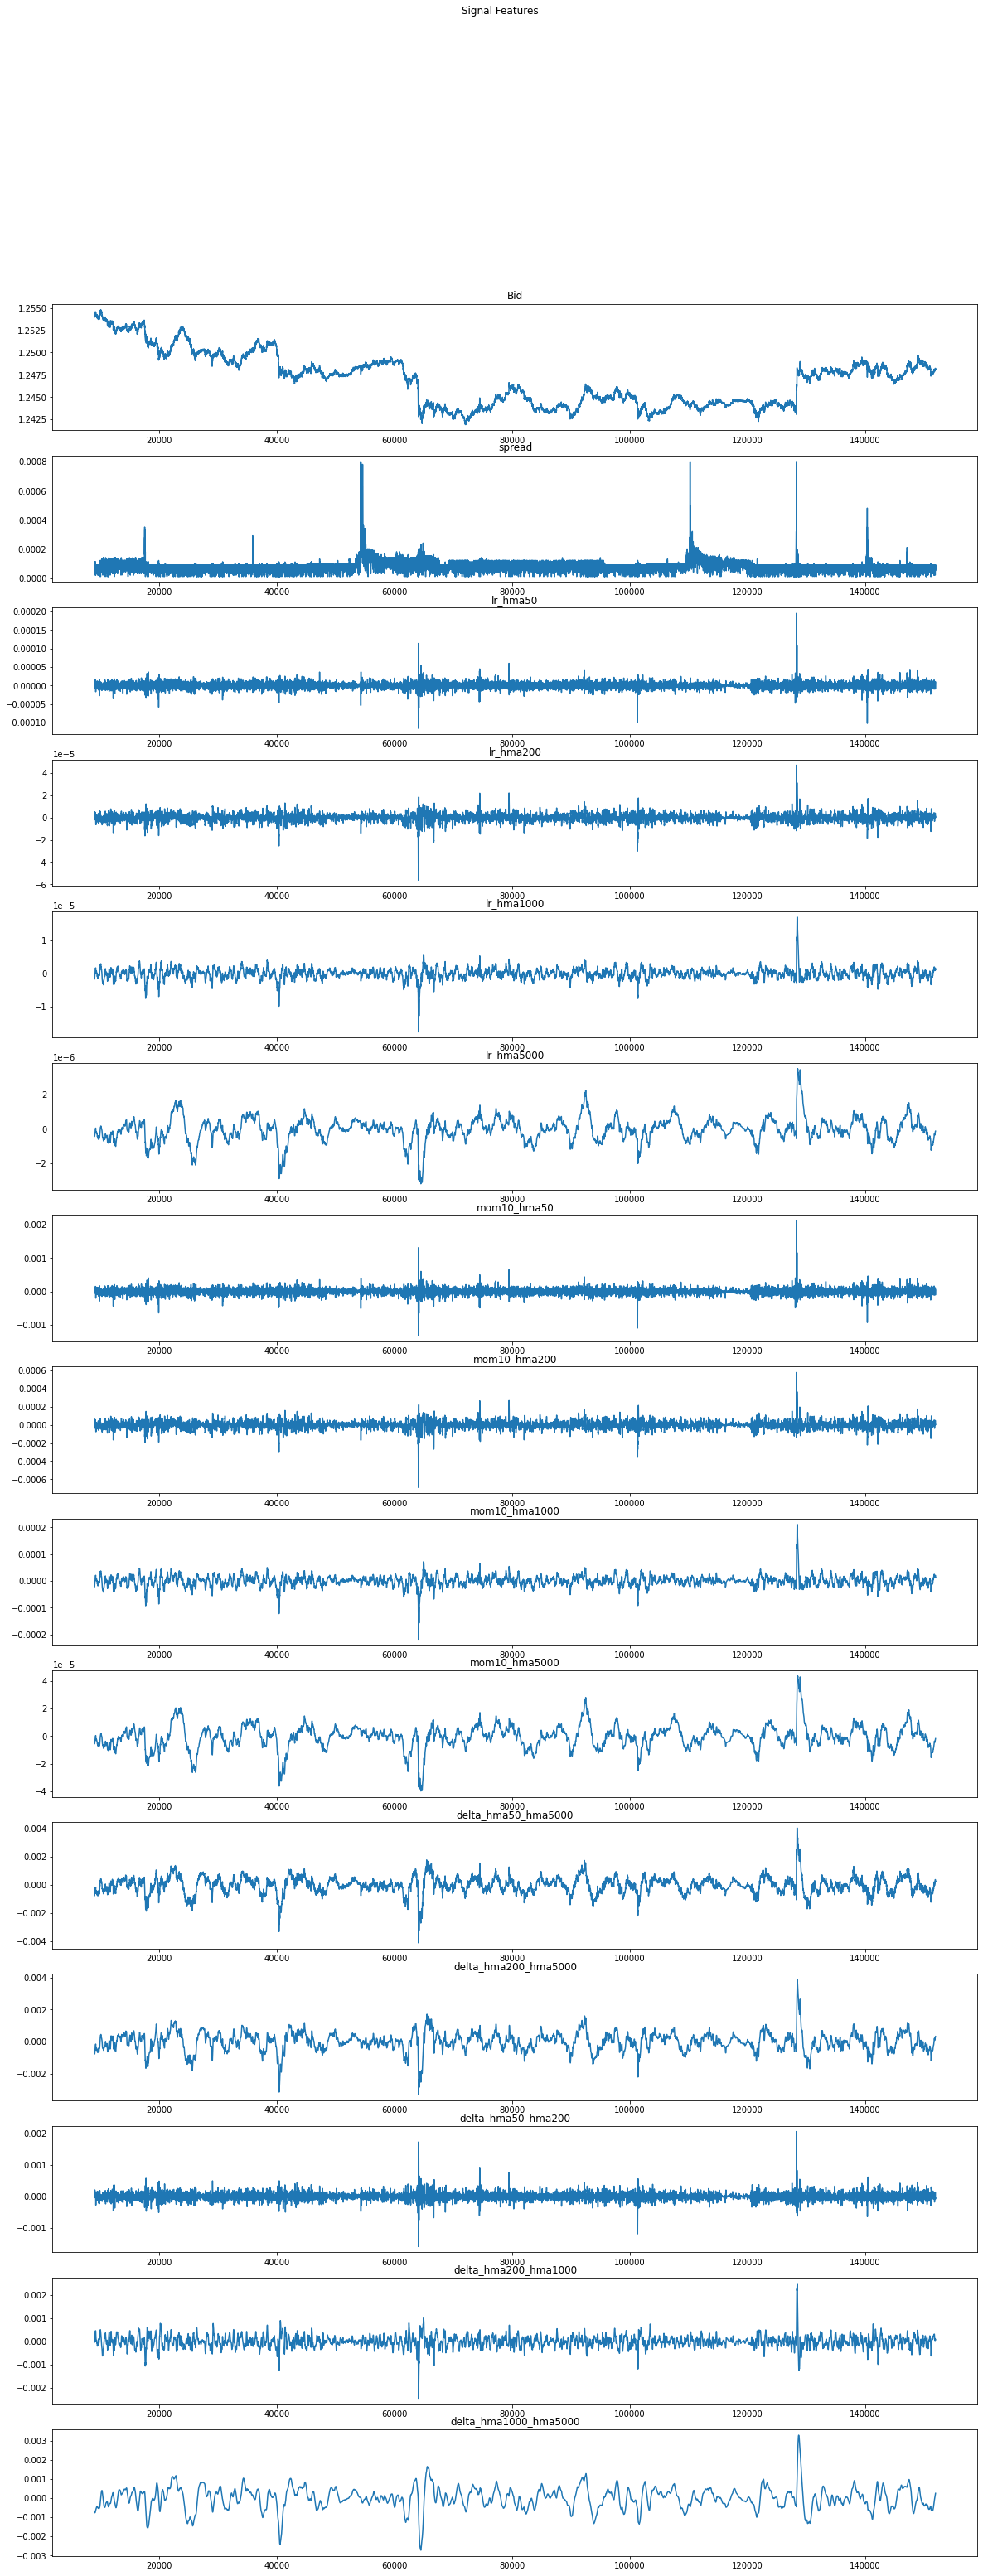

In [5]:
# plot 

rowsList = list(range(4000,146828))

fig, axs = plt.subplots(15, figsize=(20,50))
fig.suptitle('Signal Features')


axs[0].plot(df.bid.iloc[rowsList])
axs[0].set_title("Bid")
 
axs[1].plot(df.spread.iloc[rowsList])
axs[1].set_title("spread")

# log returns of ma's
axs[2].plot(df.lr_hma50.iloc[rowsList]) # this filters sufficiently, yet retains bid line shape with enough detail
axs[2].set_title("lr_hma50")
 
axs[3].plot(df.lr_hma200.iloc[rowsList])
axs[3].set_title("lr_hma200")
 
axs[4].plot(df.lr_hma1000.iloc[rowsList])
axs[4].set_title("lr_hma1000")
 
axs[5].plot(df.lr_hma5000.iloc[rowsList])
axs[5].set_title("lr_hma5000")

# MA momentums
axs[6].plot(df.mom10_hma50.iloc[rowsList])
axs[6].set_title("mom10_hma50")

axs[7].plot(df.mom10_hma200.iloc[rowsList])
axs[7].set_title("mom10_hma200")

axs[8].plot(df.mom10_hma1000.iloc[rowsList])
axs[8].set_title("mom10_hma1000")

axs[9].plot(df.mom10_hma5000.iloc[rowsList])
axs[9].set_title("mom10_hma5000")

# distance beteween ma's - take small period avg. minus large period => (+) is leading upwards
axs[10].plot(df.delta_hma50_hma5000.iloc[rowsList]) 
axs[10].set_title("delta_hma50_hma5000")

axs[11].plot(df.delta_hma200_hma5000.iloc[rowsList]) 
axs[11].set_title("delta_hma200_hma5000")


# adjacent ma's (neigbors by period)
axs[12].plot(df.delta_hma50_hma200.iloc[rowsList])
axs[12].set_title("delta_hma50_hma200")

axs[13].plot(df.delta_hma200_hma1000.iloc[rowsList])
axs[13].set_title("delta_hma200_hma1000")

axs[14].plot(df.delta_hma1000_hma5000.iloc[rowsList])
axs[14].set_title("delta_hma1000_hma5000")

'''
# Ratio of MA differences to largest difference (between the two extreme ma periods)
axs[15].plot(df.ratio_50delta200_tofullrange.iloc[rowsList])
axs[15].set_title("ratio_50delta200_tofullrange")

axs[16].plot(df.ratio_200delta1000_tofullrange.iloc[rowsList])
axs[16].set_title("ratio_200delta1000_tofullrange")

axs[17].plot(df.ratio_1000delta5000_tofullrange.iloc[rowsList])
axs[17].set_title("ratio_1000delta5000_tofullrange")
'''

In [68]:
# make deep copy 
features = (df[['spread','lr_hma50','lr_hma200','lr_hma1000','lr_hma5000','delta_hma50_hma5000','delta_hma50_hma200','delta_hma200_hma1000','delta_hma1000_hma5000','delta_hma200_hma5000']]).copy()

# make integer index
features['idx'] = np.arange(len(features))
features.reset_index(drop=True)
features.set_index('idx')
# print(features.head())


# Normalize features df
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

for col in features.columns:
    features[col] = min_max_scaling(features[col])

# add bid ask to features - after normalization
features['bid'] = df.bid
features['ask'] = df.ask

# make X Y for NEAT training
features['target'] = features.bid.shift(20)

# drop NA's
features.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)



X = features[['spread','lr_hma50','lr_hma200','lr_hma1000','lr_hma5000','delta_hma50_hma5000','delta_hma50_hma200','delta_hma200_hma1000','delta_hma1000_hma5000','delta_hma200_hma5000']]
Y = features.target

print(features.describe())

print(features.columns)

             spread      lr_hma50     lr_hma200    lr_hma1000    lr_hma5000  \
count  1.171099e+06  1.171099e+06  1.171099e+06  1.171099e+06  1.171099e+06   
mean   1.144303e-01  3.347796e-01  3.922080e-01  2.767762e-01  2.724974e-01   
std    7.027182e-02  1.772840e-02  1.536463e-02  2.308102e-02  4.274729e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    8.860759e-02  3.264553e-01  3.846171e-01  2.646534e-01  2.503291e-01   
50%    1.012658e-01  3.347408e-01  3.921321e-01  2.765518e-01  2.717399e-01   
75%    1.139241e-01  3.431279e-01  3.997642e-01  2.885299e-01  2.945598e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       delta_hma50_hma5000  delta_hma50_hma200  delta_hma200_hma1000  \
count         1.171099e+06        1.171099e+06          1.171099e+06   
mean          2.612661e-01        4.189446e-01          3.162611e-01   
std           3.316774e-02        1.479278e-02          2.072266e-02   


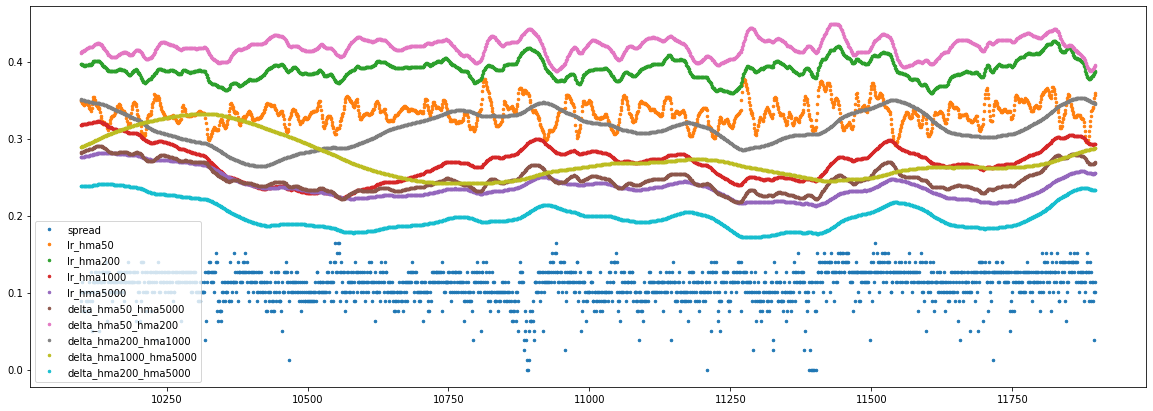

In [72]:
# examine data slices

rowsList = list(range(5000,6800))

#slice = features.iloc[rowsList, [1,2,3,4,5,6,7,8,9] ]  #  4,5,6,14,  [15,16,17]  [0,3,4,5,6] [7,8,9,10]
slice = X.iloc[rowsList,:]

#slice = df.iloc[rowsList, [7,8,9,10] ]  #  4,5,6,14,  [15,16,17],  [0,3,4,5,6], lr_'s [7,8,9,10]

# ploting parameters
mpl.rcParams['figure.figsize'] = (20, 7)     # set figure size 
mpl.rcParams['axes.grid'] = False

slice.plot(marker='.', linestyle='none', markersize=5)# ,linewidth=2, ) color='green', 

plt.show()

In [106]:
#print(X)
#_tuple =  [tuple(x) for x in X.values]
#print(_tuple)
# Create an empty list
inputs =[]
outputs=[]
# Iterate over each row
for index, rows in features.iterrows():
    # Create list for the current row
    my_list =[rows.spread, rows.lr_hma50, rows.lr_hma200, rows.lr_hma1000, rows.lr_hma5000,
       rows.delta_hma50_hma5000, rows.delta_hma50_hma200, rows.delta_hma200_hma1000,
       rows.delta_hma1000_hma5000, rows.delta_hma200_hma5000]
    my_out_list = [rows.target]
    # append the list to the final list
    inputs.append(my_list)
    outputs.append(my_out_list)
    #if index>6000: break
print(len(inputs))   
print(len(outputs)) 
# runs for 3 minutes

1171099
1171099


In [ ]:
"""
2-input XOR example -- this is most likely the simplest possible example.
from: https://github.com/CodeReclaimers/neat-python/blob/master/examples/xor/evolve-minimal.py
"""

# 2-input XOR inputs and expected outputs.
#inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)] # xor_inputs
#outputs = [(0.0,), (1.0,), (1.0,), (0.0,)] # xor_outputs
# xor inputs and outputs are replaced by list of input, output tuples from above cell/s

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(inputs, outputs):   # xor_outputs
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2


# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config-feedforward')

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

# Run until a solution is found.
winner = p.run(eval_genomes)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for xi, xo in zip(inputs, outputs):
    output = winner_net.activate(xi)
    outputRounded = round(output[0], 0)
    print("  input {!r}, expected output {!r}, got {!r}, rounded = {!r}".format(xi, xo, output, outputRounded))


 ****** Running generation 0 ****** 

